In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facial-keypoints-detection/training.zip
/kaggle/input/facial-keypoints-detection/SampleSubmission.csv
/kaggle/input/facial-keypoints-detection/IdLookupTable.csv
/kaggle/input/facial-keypoints-detection/test.zip


In [2]:
!pip install keras-tuner
!pip install scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 98.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf

import missingno as msno
import seaborn as sns
import keras_tuner as kt
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import concatenate

2025-04-25 20:25:03.543162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745612703.786741      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745612703.860790      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("Running on TPU!")
except:
    strategy = tf.distribute.get_strategy()  # Default to GPU/CPU
    print("Running on CPU/GPU")

Running on CPU/GPU


In [5]:
class Config():
    BATCH_SIZE = 32
    IMG_SIZE = (96, 96)
    SEED = 42

In [6]:
tf.random.set_seed(Config.SEED)
np.random.seed(Config.SEED)

In [7]:
# For matplotlib
plt.rcParams['axes.facecolor'] = '#F9FAFB'
plt.rcParams['figure.facecolor'] = '#F9FAFB'
plt.rcParams['axes.edgecolor'] = '#E5E7EB'
plt.rcParams['axes.labelcolor'] = '#111827'
plt.rcParams['xtick.color'] = '#6B7280'
plt.rcParams['ytick.color'] = '#6B7280'
plt.rcParams['text.color'] = '#111827'

# Custom colors for keypoints plot
keypoint_color = '#EF4444'
highlight_color = '#14B8A6'

<div style="background-color: #4F46E5; color: white; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    Facial Keypoints Detection
</div>

<div style="background-color: #14B8A6; color: white; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    Problem Statement
</div>

The objective of this task is to predict keypoint positions on face images. This can be used as a building block in several applications, such as:

tracking faces in images and video
analysing facial expressions
detecting dysmorphic facial signs for medical diagnosis
biometrics / face recognition

<div style="background-color: #14B8A6; color: white; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    Dataset
</div>

Each predicted keypoint is specified by an (x,y) real-valued pair in the space of pixel indices. There are 15 keypoints, which represent the following elements of the face:

left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip

Left and right here refers to the point of view of the subject.

In some examples, some of the target keypoint positions are misssing (encoded as missing entries in the csv, i.e., with nothing between two commas).

The input image is given in the last field of the data files, and consists of a list of pixels (ordered by row), as integers in (0,255). The images are 96x96 pixels.

Data files

* training.csv: list of training 7049 images. Each row contains the (x,y) coordinates for 15 keypoints, and image data as row-ordered list of pixels.
* test.csv: list of 1783 test images. Each row contains ImageId and image data as row-ordered list of pixels
* submissionFileFormat.csv: list of 27124 keypoints to predict. Each row contains a RowId, ImageId, FeatureName, Location. FeatureName are "left_eye_center_x," "right_eyebrow_outer_end_y," etc. Location is what you need to predict. 

Facial regions:
- **Eyes**: 6 keypoints (left/right, center, inner/outer corners)
- **Eyebrows**: 4 keypoints
- **Nose**: 1 keypoint
- **Mouth**: 4 keypoints

<div style="background-color: #14B8A6; color: white; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    EDA
</div>

In [8]:
train_df = pd.read_csv('/kaggle/input/facial-keypoints-detection/training.zip', compression='zip')
test_df = pd.read_csv('/kaggle/input/facial-keypoints-detection/test.zip', compression='zip')
lookup_df = pd.read_csv('../input/facial-keypoints-detection/IdLookupTable.csv',header=0, sep=',', quotechar='"')
submission_df = pd.read_csv('/kaggle/input/facial-keypoints-detection/SampleSubmission.csv')

In [9]:
train_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [10]:
test_df.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [11]:
lookup_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN


Let's make dataset overview

In [12]:
train_df.shape

(7049, 31)

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

Check for missing values:

In [14]:
train_df.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

As we can see, there are a lot of missing values. Visualize missingness with heatmaps

<Axes: >

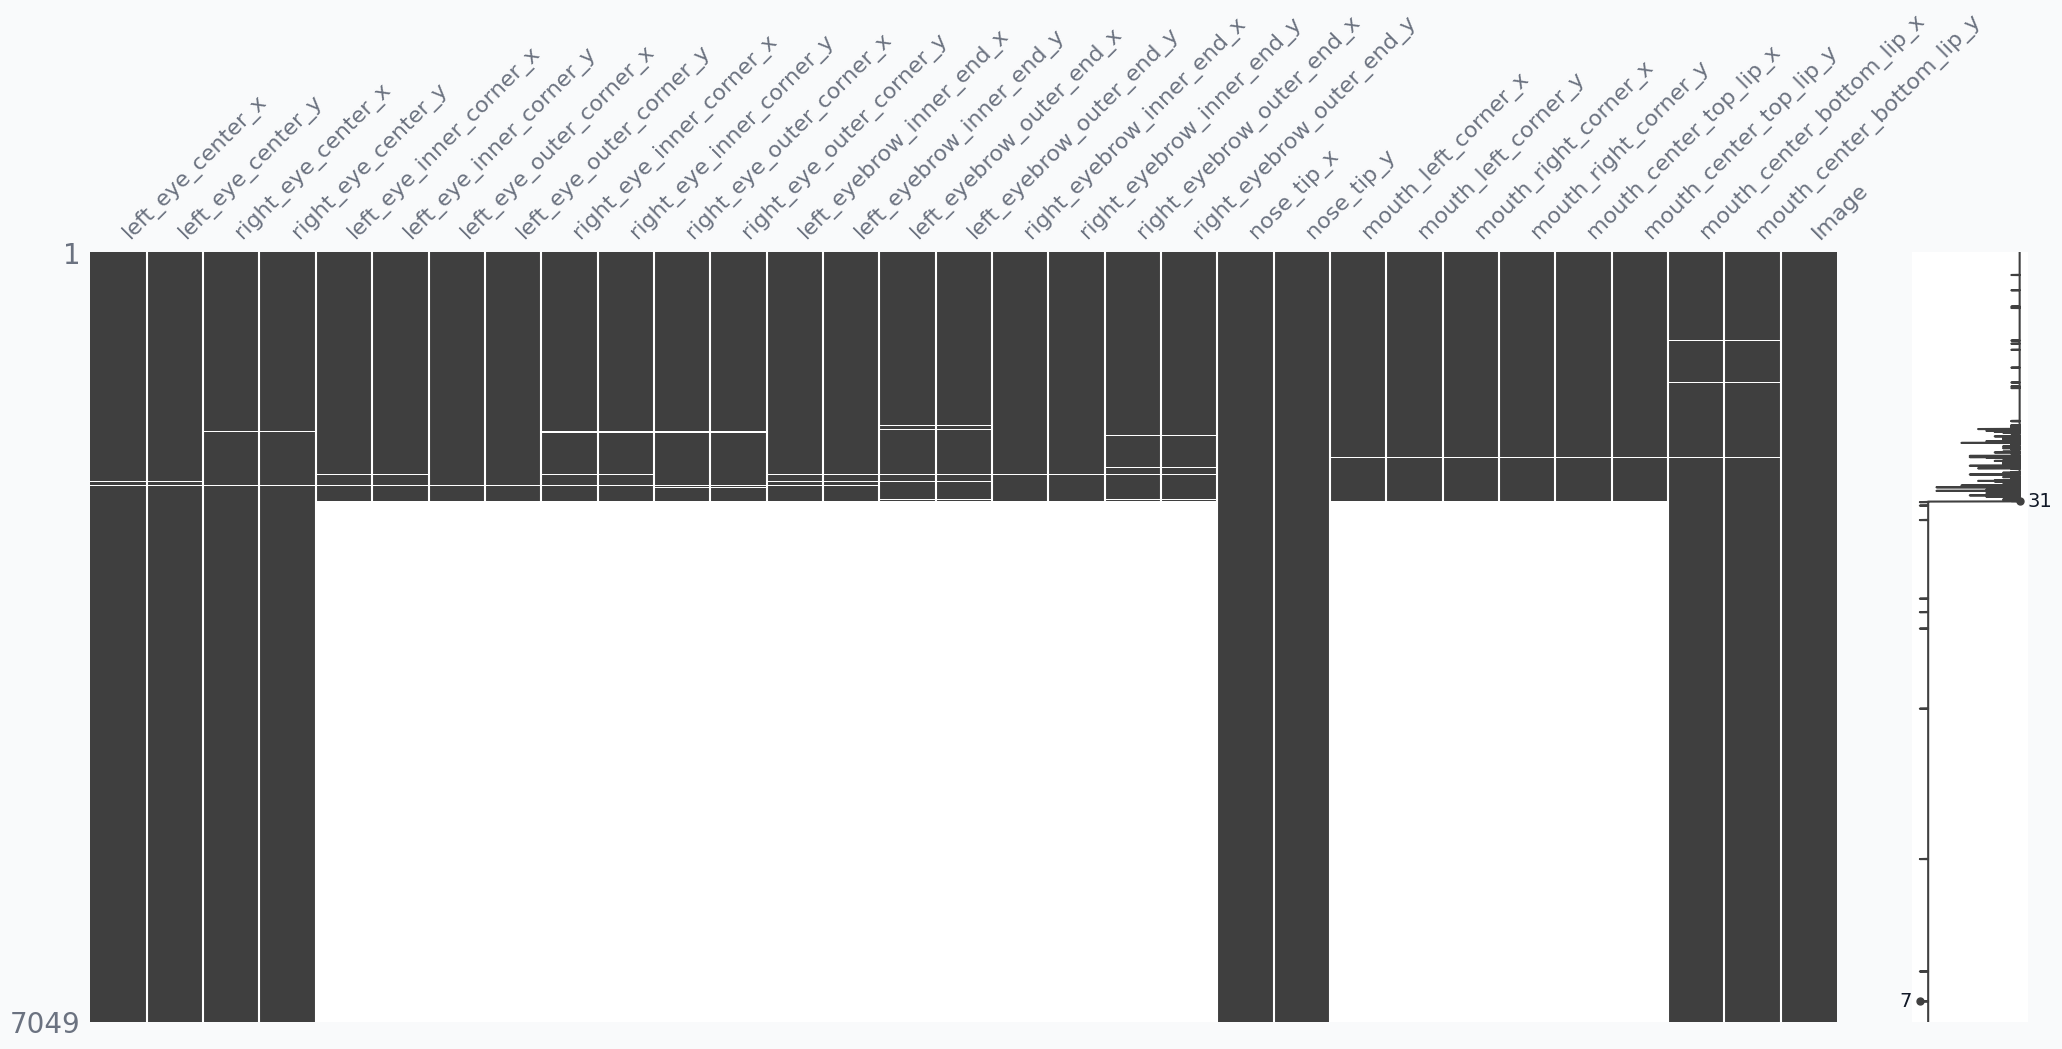

In [15]:
msno.matrix(train_df)

* **Missingness is not random**. 
There are blocks of missing keypoints, meaning entire regions are missing together in certain samples. This suggests structured missingness rather than random dropout.

* **Two dominant missing regions**. 
One block mostly missing in the mouth region.
One block around eye/eyebrow regions.


* **A few samples are fully complete**. 
You can see a narrow band (only ~31 samples) on the right of the matrix where all keypoints are present.

(array([  4.,   7.,  37.,  74., 135., 190., 253., 228., 186., 194., 195.,
        222., 223., 255., 226., 179., 196., 182., 201., 181., 192., 238.,
        243., 283., 352., 375., 380., 445., 528., 655., 718., 606., 441.,
        124.,  13.,   8.,  11.,  10.,   7.,   5.,   4.,   7.,   9.,  13.,
          8.,  26.,  72.,  39.,   5.,  31.]),
 array([  2.        ,   7.01999998,  12.03999996,  17.05999947,
         22.07999992,  27.10000038,  32.11999893,  37.13999939,
         42.15999985,  47.18000031,  52.20000076,  57.22000122,
         62.24000168,  67.26000214,  72.27999878,  77.30000305,
         82.31999969,  87.33999634,  92.36000061,  97.37999725,
        102.40000153, 107.41999817, 112.44000244, 117.45999908,
        122.48000336, 127.5       , 132.52000427, 137.53999329,
        142.55999756, 147.58000183, 152.6000061 , 157.61999512,
        162.63999939, 167.66000366, 172.67999268, 177.69999695,
        182.72000122, 187.74000549, 192.75999451, 197.77999878,
        202.800003

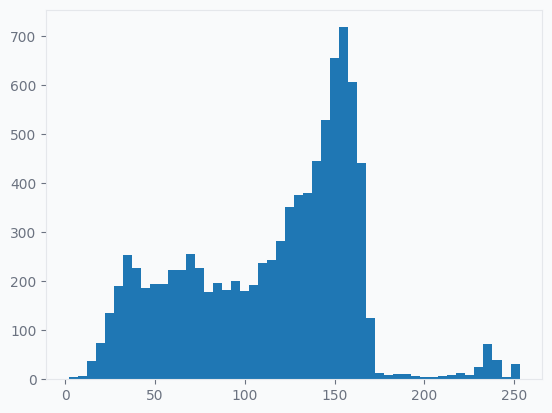

In [16]:
img = np.array(train_df['Image'][0].split(), dtype='float32').reshape(*Config.IMG_SIZE)
plt.hist(img.ravel(), bins=50)

1. Most pixels are mid-range, so the faces are likely well-contrasted against the background
2. No uniform spread → not normalized yet

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: xlabel='value', ylabel='Count'>

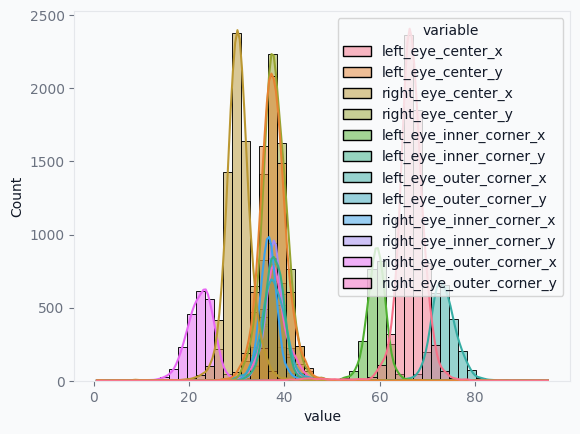

In [17]:
eye_cols = [col for col in train_df.columns if '_eye_' in col]
sns.histplot(data=train_df[eye_cols].melt(), x='value', hue='variable', kde=True, bins=50)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: xlabel='value', ylabel='Count'>

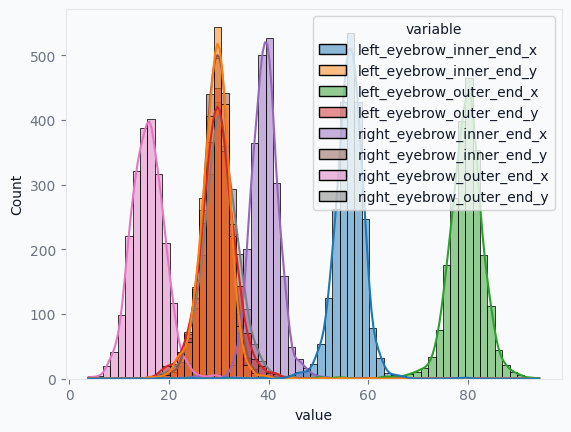

In [18]:
eyebrow_cols = [col for col in train_df.columns if '_eyebrow_' in col]
sns.histplot(data=train_df[eyebrow_cols].melt(), x='value', hue='variable', kde=True)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: xlabel='value', ylabel='Count'>

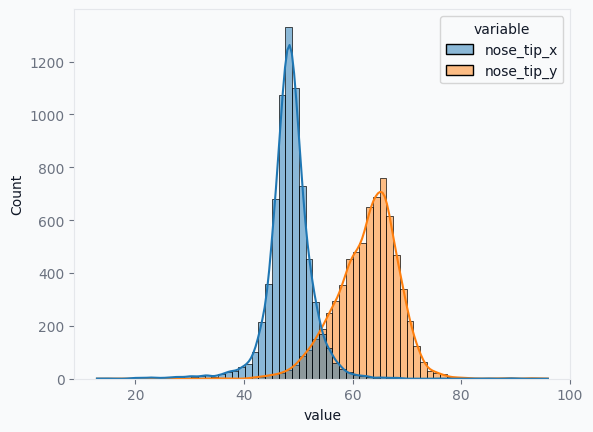

In [19]:
nose_cols = [col for col in train_df.columns if 'nose' in col]
sns.histplot(data=train_df[nose_cols].melt(), x='value', hue='variable', kde=True)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: xlabel='value', ylabel='Count'>

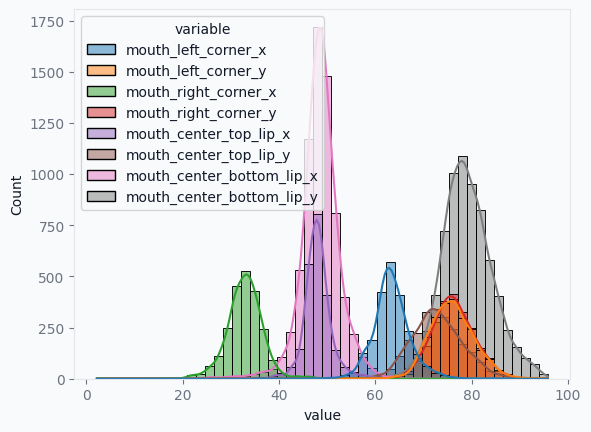

In [20]:
mouth_cols = [col for col in train_df.columns if 'mouth' in col]
sns.histplot(data=train_df[mouth_cols].melt(), x='value', hue='variable', kde=True)

Correlation Analysis

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


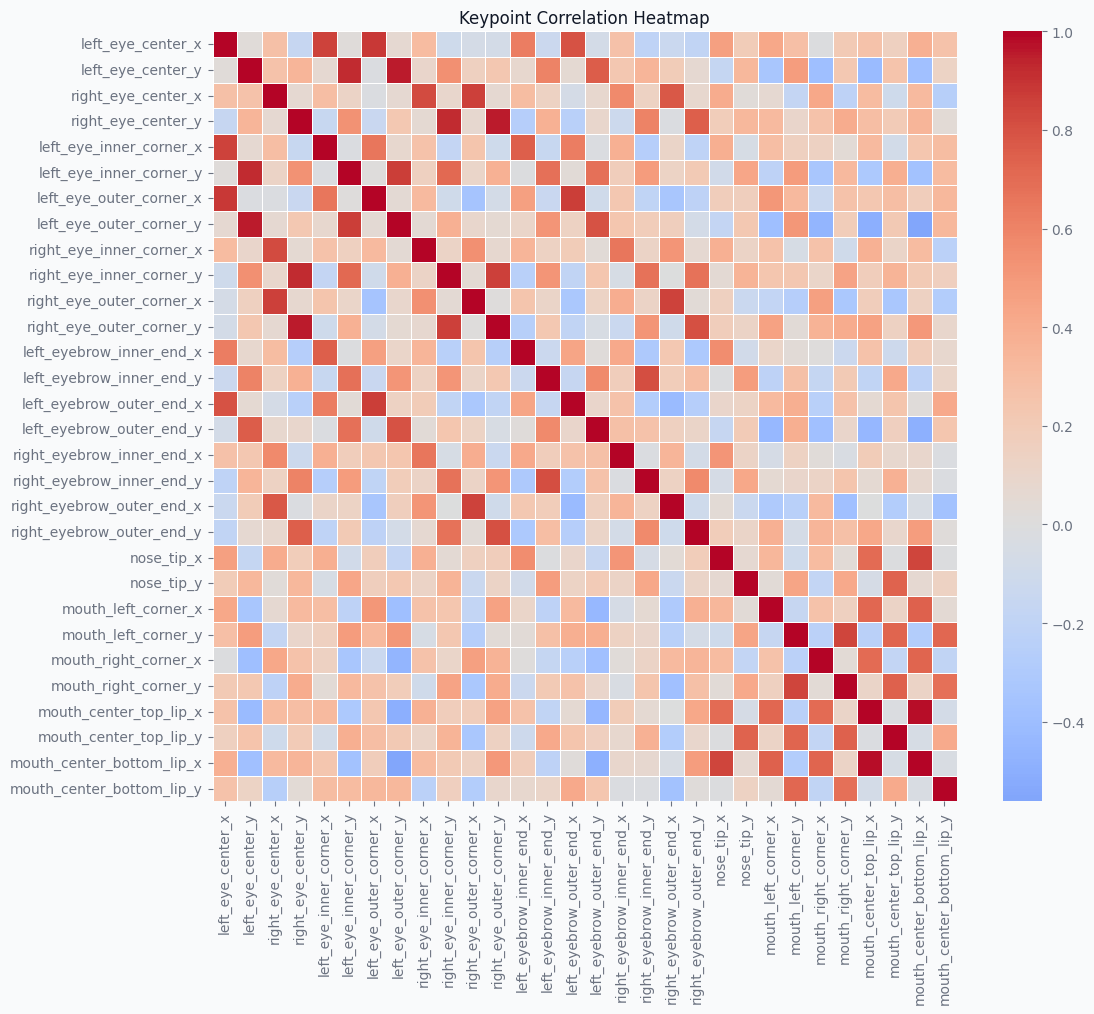

In [21]:
corr = train_df.drop(columns=['Image']).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Keypoint Correlation Heatmap")
plt.show()

In [22]:
def show_keypoints(image, keypoints):
    plt.imshow(image, cmap='gray')
    plt.scatter(keypoints[0::2], keypoints[1::2], c='red', s=10)

def visualize_sample(df, index):
    row = df.iloc[index]
    image = np.array(row['Image'].split(), dtype='float32').reshape(*Config.IMG_SIZE)
    keypoints = row[:-1].values
    show_keypoints(image, keypoints)

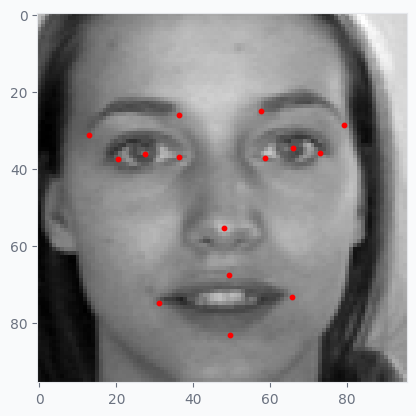

In [23]:
train_df_clean = train_df.dropna()
visualize_sample(train_df_clean, 8)

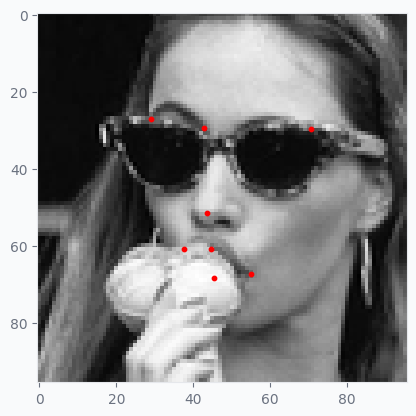

In [24]:
train_df_with_inner_eye_na = train_df[train_df['left_eye_inner_corner_x'].isna()]

visualize_sample(train_df_with_inner_eye_na, 8)

* Only ~30 samples are fully complete, so we can  might oversample them or augment them (flip, rotate, scale) to balance the dataset. This omages could be used for validation since they have full supervision
* Need to normalize pixel values to [0, 1] or [-1, 1]
* Possibly standardize using mean & std

We hypothesize:
- **Eye and nose keypoints** are more consistently labeled and central to face structure, making them easier to predict.
- **Mouth and eyebrows** have more variation (expression, occlusion), so predictions may be less stable.

<div style="background-color: #14B8A6; color: white; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    Data Preprocessing
</div>

Let's fill missing keypoints

In [25]:
train_df.fillna(method = 'ffill', inplace=True)

/tmp/ipykernel_19/4255040308.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df.fillna(method = 'ffill', inplace=True)


In [26]:
train_df.isnull().sum().any()

False

In [27]:
# convert image column to 96x96 float32 arrays
def process_image(img_str):
    img = np.array(img_str.split(), dtype=np.float32).reshape(Config.IMG_SIZE)
    img = img / 255.0  # normalize to [0,1]
    return img

train_df['Image'] = train_df['Image'].apply(process_image)

In [28]:
# extract inputs and labels
X = np.stack(train_df['Image'].values)
X = np.expand_dims(X, axis=-1)  # shape: (n_samples, 96, 96, 1)

y = train_df.drop(columns=['Image']).values.astype(np.float32)  # shape: (n_samples, 30)

We'll apply augmentation to full training dataset

In [29]:
def augment_image(image, keypoints):
    # Apply random horizontal flip
    if tf.random.uniform([]) > 0.5:
        image = tf.image.flip_left_right(image)
        # Flip X coordinates: x_new = 96 - x
        keypoints = tf.concat([96 - keypoints[..., ::2], keypoints[..., 1::2]], axis=-1)
    
    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.1)

    # Random contrast
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

    return image, keypoints

def augment_image_with_mask(image, keypoints, mask):
    image, keypoints = augment_image(image, keypoints)
    return image, keypoints, mask

Let's create a TensorFlow dataset

In [30]:
# Build a tf.data pipeline
def create_tf_dataset(X, y, mask=None, batch_size=Config.BATCH_SIZE, augment=False):
    if mask is not None:
        dataset = tf.data.Dataset.from_tensor_slices((X, y, mask))
        if augment:
            dataset = dataset.map(augment_image_with_mask, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = tf.data.Dataset.from_tensor_slices((X, y))
        if augment:
            dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.shuffle(buffer_size=1024)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

Split dataset into training and validation (20%)

In [31]:
total_samples = len(X)
val_size = int(0.2 * total_samples)

train_X, val_X = X[val_size:], X[:val_size]
train_y, val_y = y[val_size:], y[:val_size]

train_ds = create_tf_dataset(train_X, train_y, mask=None, augment=True)
val_ds = create_tf_dataset(val_X, val_y, mask=None, augment=False)

I0000 00:00:1745612744.055591      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745612744.056245      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


<div style="background-color: #14B8A6; color: white; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    Modeling - Basic CNN
</div>

CNNs (Convolutional Neural Networks) are well-suited for facial keypoints detection and other image-based tasks. CNNs use small filters (kernels) that scan over the image to detect local patterns (like edges, curves, corners). Facial keypoints benefit from CNN's bottom-up abstraction, which captures both detail and structure.

We'll use [Keras Tuner](https://keras.io/keras_tuner/) to fing the best hyperparameters.

CNN model expects a grayscale image with shape **96x96x1**.

In [32]:
def build_cnn_1_model(hp):
    model = Sequential([
        Input(shape=(*Config.IMG_SIZE, 1)),
        
        Conv2D(256, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        
        Conv2D(hp.Int("conv_units", 64, 128, step=64), (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        
        GlobalAveragePooling2D(),
        Dense(hp.Int("dense_units", 128, 256, step=128), activation='relu'),
        Dropout(0.3),
        Dense(128,activation='relu'),
        Dropout(0.1),
        Dense(30)
])
    model.compile(optimizer=Adam(hp.Choice("learning_rate", [1e-4, 1e-3])),  
                                 metrics=[RootMeanSquaredError()], 
                                 loss='mse')
    return model

cnn_1_tuner = kt.RandomSearch(
    build_cnn_1_model,
    objective=kt.Objective("val_root_mean_squared_error", direction="min"),
    max_trials=50,
    directory="cnn_tuning_2"
)

cnn_1_tuner.search(X, y, 
                   epochs=10, 
                   validation_split=0.2)

Trial 8 Complete [00h 01m 26s]
val_root_mean_squared_error: 27.375585556030273

Best val_root_mean_squared_error So Far: 2.9477834701538086
Total elapsed time: 00h 10m 39s


In [33]:
cnn_1_tuner.results_summary()

Results summary
Results in cnn_tuning_2/untitled_project
Showing 10 best trials
Objective(name="val_root_mean_squared_error", direction="min")

Trial 05 summary
Hyperparameters:
conv_units: 128
dense_units: 128
learning_rate: 0.0001
Score: 2.9477834701538086

Trial 02 summary
Hyperparameters:
conv_units: 64
dense_units: 128
learning_rate: 0.0001
Score: 3.746133327484131

Trial 06 summary
Hyperparameters:
conv_units: 128
dense_units: 256
learning_rate: 0.0001
Score: 4.287017822265625

Trial 04 summary
Hyperparameters:
conv_units: 64
dense_units: 256
learning_rate: 0.0001
Score: 5.203749656677246

Trial 01 summary
Hyperparameters:
conv_units: 64
dense_units: 256
learning_rate: 0.001
Score: 10.442258834838867

Trial 03 summary
Hyperparameters:
conv_units: 64
dense_units: 128
learning_rate: 0.001
Score: 22.149341583251953

Trial 00 summary
Hyperparameters:
conv_units: 128
dense_units: 128
learning_rate: 0.001
Score: 24.278287887573242

Trial 07 summary
Hyperparameters:
conv_units: 128
dens

In [34]:
cnn_1_model = cnn_1_tuner.get_best_models(num_models=1)[0]
cnn_1_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 256)         │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 96, 96, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 336,030 (1.28 MB)

 Trainable params: 335,262 (1.28 MB)

 Non-trainable params: 768 (3.00 KB)

<div style="background-color: #14B8A6; color: white; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    Modeling - Region Specific CNN
</div>

One-size-fits-all models may struggle to balance learning for all regions at once. Region-specific models can focus more deeply on their target area.

We will try to split dataset into eye/nose and mouth/eyebrow subsets and train separate models on them.

Let's define region keypoints:

In [35]:
EYE_NOSE_POINTS = [c for c in list(train_df.columns) if ('eye_' in c or 'nose' in c)]
EYE_NOSE_POINTS.append('Image')

MOUTH_EYEBROW_POINTS = [c for c in list(train_df.columns) if ('mouth' in c or 'eyebrow' in c)]
MOUTH_EYEBROW_POINTS.append('Image')

In [36]:
eye_nose_df = train_df[EYE_NOSE_POINTS]
X_eye_nose = np.stack(eye_nose_df['Image'].values)
X_eye_nose = np.expand_dims(X_eye_nose, axis=-1)  # shape: (n_samples, 96, 96, 1)

y_eye_nose = eye_nose_df.drop(columns=['Image']).values.astype(np.float32)  # shape: (n_samples, 30)

In [37]:
mouth_eyebrow_df = train_df[MOUTH_EYEBROW_POINTS]
X_mouth_eyebrow = np.stack(mouth_eyebrow_df['Image'].values)
X_mouth_eyebrow = np.expand_dims(X_mouth_eyebrow, axis=-1)  # shape: (n_samples, 96, 96, 1)

y_mouth_eyebrow = mouth_eyebrow_df.drop(columns=['Image']).values.astype(np.float32)  # shape: (n_samples, 30)

In [38]:
train_X_eye_nose, val_X_eye_nose = X_eye_nose[val_size:], X_eye_nose[:val_size]
train_y_eye_nose, val_y_eye_nose = y_eye_nose[val_size:], y_eye_nose[:val_size]

train_eye_nose_ds = create_tf_dataset(train_X_eye_nose, train_y_eye_nose, mask=None, augment=True)
val_eye_nose_ds = create_tf_dataset(val_X_eye_nose, val_y_eye_nose, mask=None, augment=False)

In [39]:
train_X_mouth_eyebrow, val_X_mouth_eyebrow = X_mouth_eyebrow[val_size:], X_mouth_eyebrow[:val_size]
train_y_mouth_eyebrow, val_y_mouth_eyebrow = y_mouth_eyebrow[val_size:], y_mouth_eyebrow[:val_size]

train_mouth_eyebrow_ds = create_tf_dataset(train_X_mouth_eyebrow, train_y_mouth_eyebrow, mask=None, augment=True)
val_mouth_eyebrow_ds = create_tf_dataset(val_X_mouth_eyebrow, val_y_mouth_eyebrow, mask=None, augment=False)

In [40]:
def build_eye_nose_model(hp):
    model = Sequential([
        Input(shape=(*Config.IMG_SIZE, 1)),

        Conv2D(hp.Int("conv_units_1", 32, 64, step=32), (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        
        Conv2D(hp.Int("conv_units_2", 64, 128, step=64), (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        
        GlobalAveragePooling2D(),
        Dense(hp.Int("dense_units", 128, 256, step=128), activation='relu'),
        Dropout(0.3),
        Dense(128,activation='relu'),
        Dropout(0.1),
        Dense(14)
])
    model.compile(optimizer=Adam(hp.Choice("learning_rate", [1e-4, 1e-3])),  
                                 metrics=[RootMeanSquaredError()], 
                                 loss='mse')
    return model

In [41]:
eye_nose_tuner = kt.RandomSearch(
    build_eye_nose_model,
    objective=kt.Objective("val_root_mean_squared_error", direction="min"),
    max_trials=50,
    directory="tuning_eye_nose"
)

eye_nose_tuner.search(X_eye_nose, 
                      y_eye_nose, 
                       epochs=10, 
                       validation_split=0.2)

Trial 15 Complete [00h 00m 25s]
val_root_mean_squared_error: 3.494744062423706

Best val_root_mean_squared_error So Far: 2.8553667068481445
Total elapsed time: 00h 08m 00s


In [42]:
def build_mouth_eyebrow_model(hp):
    model = Sequential([
        Input(shape=(*Config.IMG_SIZE, 1)),

        Conv2D(256, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        
        Conv2D(hp.Int("conv_units", 64, 128, step=64), (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        
        GlobalAveragePooling2D(),
        Dense(hp.Int("dense_units", 128, 256, step=128), activation='relu'),
        Dropout(0.3),
        Dense(128,activation='relu'),
        Dropout(0.1),
        Dense(16)
])
    model.compile(optimizer=Adam(hp.Choice("learning_rate", [1e-4, 1e-3])),  
                                 metrics=[RootMeanSquaredError()], 
                                 loss='mse')
    return model

In [43]:
mouth_eyebrow_tuner = kt.RandomSearch(
    build_mouth_eyebrow_model,
    objective=kt.Objective("val_root_mean_squared_error", direction="min"),
    max_trials=50,
    directory="tuning_mouth_eyebrow"
)

mouth_eyebrow_tuner.search(X_mouth_eyebrow, 
                                  y_mouth_eyebrow, 
                                  epochs=10, 
                                  validation_split=0.2)

Trial 8 Complete [00h 01m 27s]
val_root_mean_squared_error: 3.323312520980835

Best val_root_mean_squared_error So Far: 3.323312520980835
Total elapsed time: 00h 10m 38s


In [44]:
eye_nose_tuner.results_summary()

Results summary
Results in tuning_eye_nose/untitled_project
Showing 10 best trials
Objective(name="val_root_mean_squared_error", direction="min")

Trial 11 summary
Hyperparameters:
conv_units_1: 32
conv_units_2: 128
dense_units: 128
learning_rate: 0.001
Score: 2.8553667068481445

Trial 12 summary
Hyperparameters:
conv_units_1: 64
conv_units_2: 64
dense_units: 256
learning_rate: 0.0001
Score: 3.0840415954589844

Trial 07 summary
Hyperparameters:
conv_units_1: 32
conv_units_2: 64
dense_units: 256
learning_rate: 0.0001
Score: 3.127163887023926

Trial 05 summary
Hyperparameters:
conv_units_1: 64
conv_units_2: 128
dense_units: 256
learning_rate: 0.001
Score: 3.16558575630188

Trial 08 summary
Hyperparameters:
conv_units_1: 64
conv_units_2: 64
dense_units: 128
learning_rate: 0.0001
Score: 3.2802224159240723

Trial 00 summary
Hyperparameters:
conv_units_1: 64
conv_units_2: 128
dense_units: 256
learning_rate: 0.0001
Score: 3.392556667327881

Trial 13 summary
Hyperparameters:
conv_units_1: 32
c

In [45]:
mouth_eyebrow_tuner.results_summary()

Results summary
Results in tuning_mouth_eyebrow/untitled_project
Showing 10 best trials
Objective(name="val_root_mean_squared_error", direction="min")

Trial 07 summary
Hyperparameters:
conv_units: 128
dense_units: 256
learning_rate: 0.0001
Score: 3.323312520980835

Trial 02 summary
Hyperparameters:
conv_units: 64
dense_units: 256
learning_rate: 0.0001
Score: 3.4108057022094727

Trial 06 summary
Hyperparameters:
conv_units: 64
dense_units: 128
learning_rate: 0.0001
Score: 3.6213788986206055

Trial 05 summary
Hyperparameters:
conv_units: 128
dense_units: 128
learning_rate: 0.0001
Score: 5.990959167480469

Trial 00 summary
Hyperparameters:
conv_units: 128
dense_units: 256
learning_rate: 0.001
Score: 15.594590187072754

Trial 04 summary
Hyperparameters:
conv_units: 64
dense_units: 256
learning_rate: 0.001
Score: 18.12327766418457

Trial 03 summary
Hyperparameters:
conv_units: 128
dense_units: 128
learning_rate: 0.001
Score: 25.639339447021484

Trial 01 summary
Hyperparameters:
conv_units:

Best models:

In [46]:
best_eye_nose_model = eye_nose_tuner.get_best_models(1)[0]
best_eye_nose_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 96, 96, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 128)         │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 14)                  │           1,806 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,782 (284.30 KB)

 Trainable params: 72,462 (283.05 KB)

 Non-trainable params: 320 (1.25 KB)

In [47]:
best_mouth_eyebrow_model = mouth_eyebrow_tuner.get_best_models(1)[0]
best_mouth_eyebrow_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 256)         │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 96, 96, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │           2,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 367,120 (1.40 MB)

 Trainable params: 366,352 (1.40 MB)

 Non-trainable params: 768 (3.00 KB)

Build Multi-Input, Multi-Architecture Model

In [48]:
def build_combined_model():
    inputs = Input(shape=(96, 96, 1))

    # Branch 1: block for eyes/nose
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x1 = MaxPooling2D()(x1)
    x1 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
    x1 = MaxPooling2D()(x1)
    x1 = GlobalAveragePooling2D()(x1)
    x1 = Dense(256, activation='relu')(x1)
    x1 = Dropout(0.3)(x1)

    out1 = Dense(14, name="eye_nose")(x1)
    
    # Branch 2: block for mouth/eyebrows
    x2 = Conv2D(256, (3, 3), activation='relu', padding='same')(inputs)
    x2 = MaxPooling2D()(x2)
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
    x2 = MaxPooling2D()(x2)
    x2 = GlobalAveragePooling2D()(x2)
    x2 = Dense(128, activation='relu')(x2)
    x2 = Dropout(0.3)(x2)
    
    out2 = Dense(16, name="mouth_eyebrow")(x2)
    
    # Combine outputs
    outputs = concatenate([out1, out2], name='combined_output')

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        metrics=[RootMeanSquaredError()], 
        loss='mse'
    )
    
    return model

Let's train the best models. We will use EarlyStopping and ReduceLROnPlateau (learning rate reduction) to prevent extreme overfitting.

In [49]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_root_mean_squared_error', 
                                            factor=0.5, 
                                            patience=5, 
                                            min_lr=1e-7)

earlystop = EarlyStopping(monitor='val_root_mean_squared_error', 
                          patience=5, 
                          restore_best_weights=True)

In [50]:
basic_hps = cnn_1_tuner.get_best_hyperparameters(num_trials=1)[0]

basic_model = build_cnn_1_model(basic_hps)

basic_history = basic_model.fit(X, y,
                                  epochs=100, 
                                  validation_split=0.2, 
                                  callbacks=[learning_rate_reduction, earlystop])

Epoch 1/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - loss: 2552.3574 - root_mean_squared_error: 50.5095 - val_loss: 2593.0710 - val_root_mean_squared_error: 50.9222 - learning_rate: 1.0000e-04
Epoch 2/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 688.4706 - root_mean_squared_error: 25.7727 - val_loss: 816.0833 - val_root_mean_squared_error: 28.5672 - learning_rate: 1.0000e-04
Epoch 3/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 81.1043 - root_mean_squared_error: 9.0001 - val_loss: 38.2050 - val_root_mean_squared_error: 6.1810 - learning_rate: 1.0000e-04
Epoch 4/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 63.8274 - root_mean_squared_error: 7.9889 - val_loss: 26.1435 - val_root_mean_squared_error: 5.1131 - learning_rate: 1.0000e-04
Epoch 5/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 60.4060 - root_mean_squared_error: 7.7716 - val_loss: 47.2738 - val_root_mean_squared_error: 6.8756 - learning_rate: 1.0000e-04
Epoch 6/100
177/177 ━━━━━━━━━━━━━━━━━━━

In [51]:
region_model = build_combined_model()
region_history = region_model.fit(X, y,
                                  epochs=100, 
                                  validation_split=0.2, 
                                  callbacks=[learning_rate_reduction, earlystop])

Epoch 1/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - loss: 1207.5226 - root_mean_squared_error: 33.4283 - val_loss: 31.4196 - val_root_mean_squared_error: 5.6053 - learning_rate: 0.0010
Epoch 2/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 68.0285 - root_mean_squared_error: 8.2352 - val_loss: 8.1556 - val_root_mean_squared_error: 2.8558 - learning_rate: 0.0010
Epoch 3/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 47.8826 - root_mean_squared_error: 6.9192 - val_loss: 13.5256 - val_root_mean_squared_error: 3.6777 - learning_rate: 0.0010
Epoch 4/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 41.7882 - root_mean_squared_error: 6.4639 - val_loss: 8.3668 - val_root_mean_squared_error: 2.8925 - learning_rate: 0.0010
Epoch 5/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 37.7079 - root_mean_squared_error: 6.1406 - val_loss: 7.1726 - val_root_mean_squared_error: 2.6782 - learning_rate: 0.0010
Epoch 6/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 36.4005

<div style="background-color: #14B8A6; color: white; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    Evaluation
</div>

In [52]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # --- Plot Loss ---
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # --- Plot RMSE ---
    plt.subplot(1, 2, 2)
    plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
    plt.plot(history.history['val_root_mean_squared_error'], label='Val RMSE')
    plt.title('RMSE over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()

    plt.tight_layout()
    plt.show()

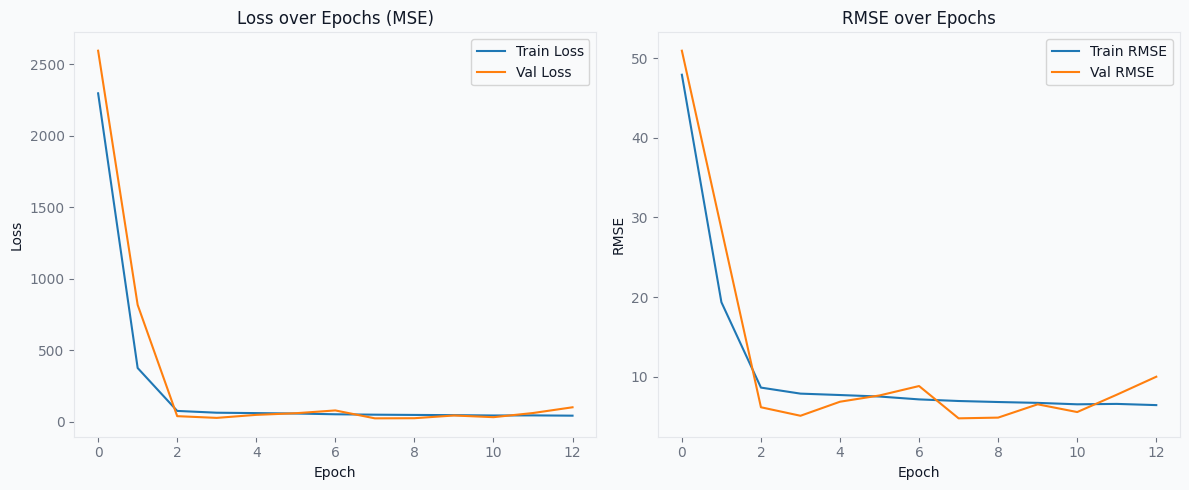

In [53]:
plot_history(basic_history)

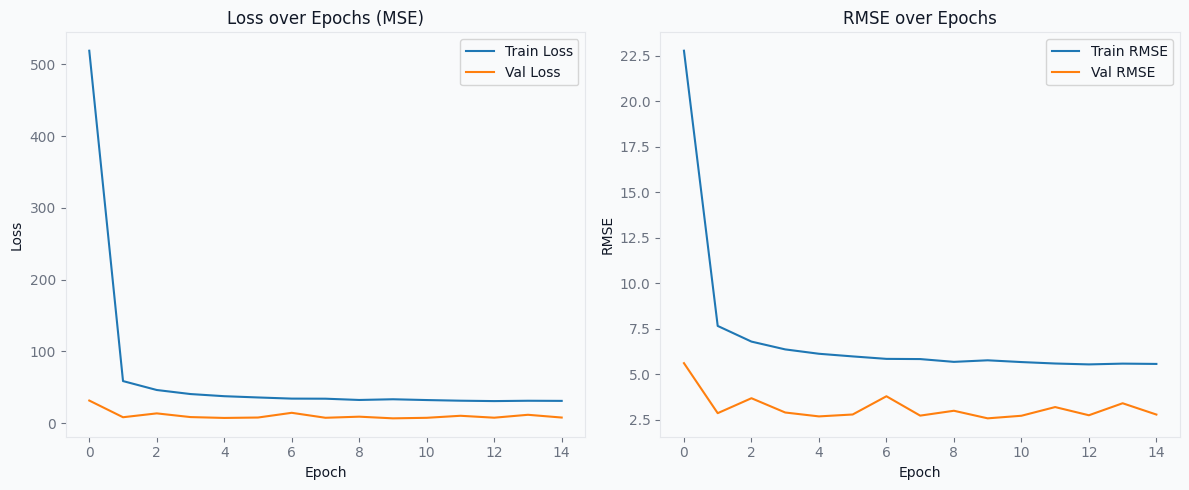

In [54]:
plot_history(region_history)

### Observations:
- Both models learn quickly.
- Region model shows slightly lower and more stable validation RMSE, that suggests better generalization and less noisy or overfit behavior.
- Adding dropout + L2 reduced overfitting significantly.
- Mouth keypoints are hardest to predict due to expression variance.
- Smaller, focused models can outperform a full-face model in local regions.

<div style="background-color: #14B8A6; color: white; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    Submission
</div>

In [55]:
test_df['Image'] = test_df['Image'].apply(process_image)

In [56]:
def create_test_tf_dataset(X, batch_size=Config.BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(X)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [57]:
X_test = np.stack(test_df['Image'].values)
X_test = np.expand_dims(X_test, axis=-1)  # Shape: (n_samples, 96, 96, 1)

test_ds = create_test_tf_dataset(X_test)

In [58]:
predictions_basic = basic_model.predict(X_test)
predictions_region = region_model.predict(X_test)

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


In [59]:
feature_names = train_df.columns[:-1]

In [60]:
submission_basic = lookup_df.copy()

for i, row in submission_basic.iterrows():
    image_index = int(row['ImageId']) - 1  # ImageId starts at 1
    feature_name = row['FeatureName']
    feature_idx = feature_names.get_loc(feature_name)

    # Get the predicted value
    pred_value = predictions_basic[image_index][feature_idx]

    # Fill in Location
    submission_basic.at[i, 'Location'] = pred_value

In [61]:
submission_basic['Location'] = submission_basic['Location'].clip(0, 96)

In [62]:
submission_basic.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,70.008492
1,2,1,left_eye_center_y,39.771732
2,3,1,right_eye_center_x,31.767645
3,4,1,right_eye_center_y,39.989708
4,5,1,left_eye_inner_corner_x,62.068718


In [63]:
def show_image_with_keypoints(image, keypoints, title=None):
    """
    Show 96x96 image with 15 (x, y) keypoint pairs.
    """
    plt.imshow(image.squeeze(), cmap='gray')
    
    # Plot x and y in pairs
    x_points = keypoints[0::2]
    y_points = keypoints[1::2]
    
    plt.scatter(x_points, y_points, c='red', s=20)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

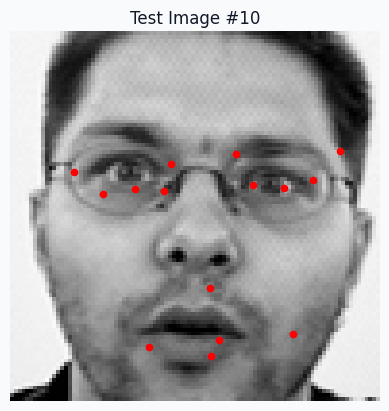

In [64]:
index = 10

# Get image and prediction
img = X_test[index]
pred = predictions_basic[index]

# Show
show_image_with_keypoints(img, pred, title=f"Test Image #{index}")

In [65]:
submission_basic[['RowId', 'Location']].to_csv('submission_basic.csv', index=False)

In [66]:
submission_region = lookup_df.copy()

for i, row in submission_region.iterrows():
    image_index = int(row['ImageId']) - 1  # ImageId starts at 1
    feature_name = row['FeatureName']
    feature_idx = feature_names.get_loc(feature_name)

    # Get the predicted value
    pred_value = predictions_region[image_index][feature_idx]

    # Fill in Location
    submission_region.at[i, 'Location'] = pred_value

In [67]:
submission_region['Location'] = submission_region['Location'].clip(0, 96)

In [68]:
submission_region.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,66.468254
1,2,1,left_eye_center_y,37.824509
2,3,1,right_eye_center_x,30.200321
3,4,1,right_eye_center_y,37.944008
4,5,1,left_eye_inner_corner_x,59.368755


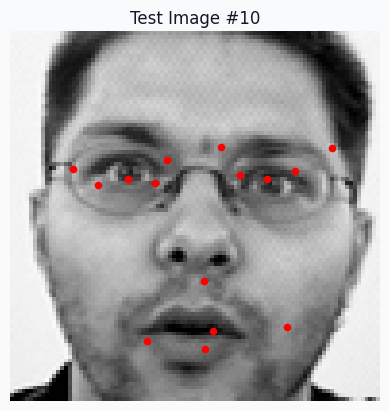

In [69]:
index = 10

# Get image and prediction
img = X_test[index]
pred = predictions_region[index]

# Show
show_image_with_keypoints(img, pred, title=f"Test Image #{index}")

In [70]:
submission_region[['RowId', 'Location']].to_csv('submission_region.csv', index=False)

<div style="background-color: #14B8A6; color: white; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    Conclusion
</div>

In this project, we developed and evaluated deep learning models for facial keypoints detection, a regression task aimed at predicting 30 (x, y) coordinates for key facial landmarks.

We began with exploratory data analysis (EDA) to understand data distributions, missingness patterns, and pixel intensity behavior. Based on these insights, we applied normalization, handled missing values, and visualized keypoint spread across the facial structure.

Modeling Insights:
- Baseline CNN models performed well initially, rapidly reducing loss in early epochs. However, slight overfitting was observed without regularization.
- Introducing region-specific models (for eye/nose and mouth/eyebrow regions) significantly improved generalization. These models had lower and more stable validation RMSE, especially on partially labeled data.
A multi-branch CNN was implemented to merge region-specific features into a unified 30-keypoint prediction, balancing specialization and scalability.

With further work, including:

- landmark refinement techniques (e.g., heatmap-based regression)
- ensembling multiple specialized models
...the accuracy and robustness of facial keypoint detection can be pushed even further.